In [27]:
%%capture
%%bash
pip install pymc3==3.8
pip install arviz==0.6.1
pip install Theano==1.0.4

mkdir data/
wget -P ./data/ https://github.com/sachinruk/bayes_school/raw/master/data/all_stocks_5yr.csv.zip 
wget -P ./data/ https://raw.githubusercontent.com/sachinruk/bayes_school/master/data/sandp500.csv

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.linear_model import LinearRegression

import theano
import pymc3 as pm
from pymc3 import plot_posterior

%matplotlib inline

The data was downloaded from https://www.kaggle.com/camnugent/sandp500

In [29]:
df = pd.read_csv('./data/all_stocks_5yr.csv.zip', compression='zip')
df.head()

Date   Open   High    Low  Close     Volume Name
0  2012-08-13  92.29  92.59  91.74  92.40  2075391.0  MMM
1  2012-08-14  92.36  92.50  92.01  92.30  1843476.0  MMM
2  2012-08-15  92.00  92.74  91.94  92.54  1983395.0  MMM
3  2012-08-16  92.75  93.87  92.21  93.74  3395145.0  MMM
4  2012-08-17  93.93  94.30  93.59  94.24  3069513.0  MMM

In [30]:
sandp500 = pd.read_csv('./data/sandp500.csv')
sandp500['Date'] = pd.to_datetime(sandp500['Date'])
sandp500 = sandp500[['Date', 'Close']]
print(sandp500.shape)
sandp500.head()

(1259, 2)


Date        Close
0 2014-07-09  1972.829956
1 2014-07-10  1964.680054
2 2014-07-11  1967.569946
3 2014-07-14  1977.099976
4 2014-07-15  1973.280029

In [31]:
stocks = ['MSFT']
df_stocks = df.loc[df.Name.isin(stocks), ['Date', 'Close']]
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])
df_stocks.shape

(1258, 2)

Merge the two dataframes

In [32]:
df_final = pd.merge(sandp500, df_stocks, on=['Date'], suffixes=('_sandp', '_MSFT'))

In [33]:
print(df_final.shape)
df_final.head()

(781, 3)


Date  Close_sandp  Close_MSFT
0 2014-07-09  1972.829956       41.67
1 2014-07-10  1964.680054       41.68
2 2014-07-11  1967.569946       42.09
3 2014-07-14  1977.099976       42.14
4 2014-07-15  1973.280029       42.45

In [34]:
cols = ['Close_sandp','Close_MSFT']
df_final.sort_values('Date', inplace=True)
df_final.reset_index(drop=True, inplace=True)
df_final[cols] = np.log(df_final[cols])

The difference of logs is the same as log of the ratio:
$$
\log p_{t} - \log p_{t-1} \equiv \log \frac{p_t}{p_{t-1}}
$$

In [35]:
df_final[cols] = df_final[cols].diff()

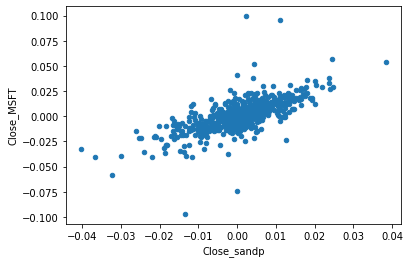

In [36]:
df_final.plot('Close_sandp', 'Close_MSFT', kind='scatter')
plt.show()

In [37]:
x = df_final['Close_sandp'].values[1:][:,None]
y = df_final['Close_MSFT'].values[1:][:,None]

## Scikit-Learn Method

In [38]:
x.shape, y.shape

((780, 1), (780, 1))

Model parameters are: [0.0003845] [[1.19160762]]


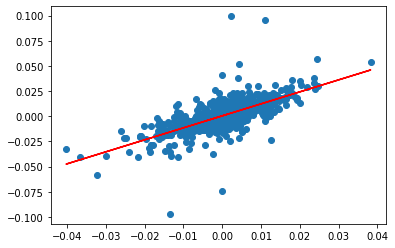

In [39]:
model = LinearRegression()
model.fit(x, y)
print('Model parameters are:', model.intercept_, model.coef_)

y_pred = model.predict(x)
plt.scatter(x,y)
plt.plot(x, y_pred, 'r')
plt.show()

## PyMC3 Model

$$
\begin{align}
r_{MSFT} &\sim \mathcal{N}(\alpha + \beta r_{SP500}, \sigma^2)\\
\alpha &\sim \mathcal{N}(0, 1)\\
\beta &\sim \mathcal{N}(0, 1)\\
\sigma &\sim U(0,1)
\end{align}
$$

You are probably more familiar with this form of the first line:
$$
\begin{align}
r_{MSFT} &= \alpha + \beta r_{SP500} + \xi \\
\xi &\sim \mathcal{N}(0, \sigma^2)
\end{align}
$$

In [40]:
x_t = x.squeeze()
y_t = y.squeeze()

n_samples=500

with pm.Model() as model:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    regression = α+β*x_t

    sd = pm.Uniform('sd', 0, 1)
    likelihood = pm.Normal('y', mu=regression, sd=sd, observed=y_t)
    trace = pm.sample(n_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, β, α]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:01<00:00, 534.45it/s]
The acceptance probability does not match the target. It is 0.9241435054087647, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9442857369785859, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
trace['α'].shape

(1000,)

In [ ]:
a_mean = trace['α'].mean(axis=0)
b_mean = trace['β'].mean(axis=0)

y_pred = a_mean + b_mean*x
print(a_mean, b_mean)

0.00041936716618434734 1.1849599994182196


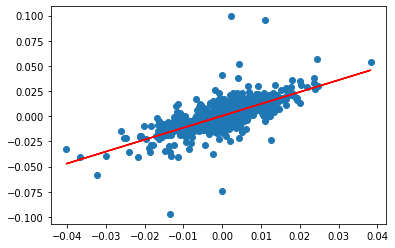

In [ ]:
plt.scatter(x, y)
plt.plot(x, y_pred, 'r')
plt.show()

Bayesian learning is far more about solving the following integral than just using Bayes Rule:
$$
\begin{align}
p(D^*|D) &= \int p(D^*|\theta)p(\theta|D) d\theta\\
&\approx \sum_{\theta\sim p(\theta|D)}p(D^*|\theta)
\end{align}
$$
We denote $D^*$ to be test data, $D$ to be the train set and $\theta$ to be a hidden parameter. This can often be thought of as doing model averaging if $p(\theta|D)$ is thought of as a weighting function.

In [ ]:
a_mean = trace['α']
b_mean = trace['β']

y_pred = a_mean + b_mean*x
y_pred.shape

(780, 1000)

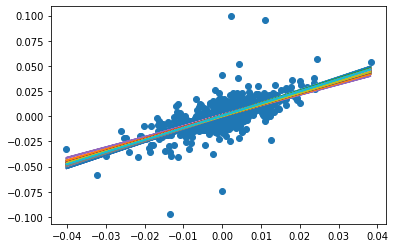

In [ ]:
idx = np.random.choice(len(y_pred), 200)

plt.scatter(x, y)
for i in idx:
    plt.plot(x, y_pred[:,i])

plt.show()

In [43]:
trace["sd"].shape, y_pred.shape

((1000,), (780, 1))

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

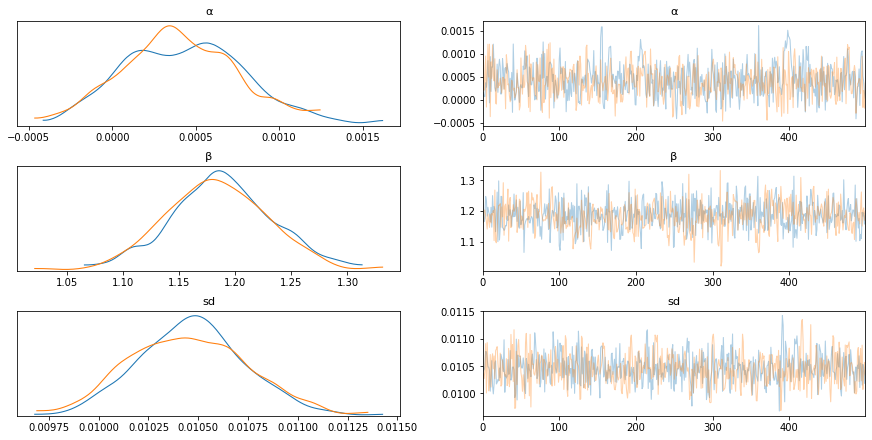

In [ ]:
pm.traceplot(trace);

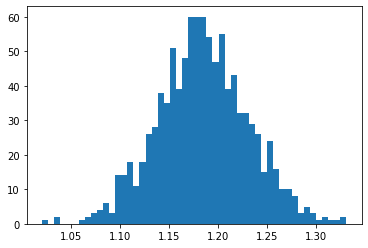

In [ ]:
plt.hist(trace['β'], 50)
plt.show()